# Hot or Bot
## Dating Recommendations with GANs, Eigenvectors, and Image Similarity

![](https://pipeline.ai/assets/img/hotorbot.png)

In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Generate Image Faces using Nvidia [StyleGan](https://github.com/NVlabs/stylegan)
![](https://github.com/NVlabs/stylegan/raw/master/stylegan-teaser.png)

In [3]:
images_path = '../../gan-images/'

len(os.listdir(os.path.join(images_path, 'gan-0')))

13986

In [4]:
batch_size = 200
img_w_size = 299
img_h_size = 299

In [5]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

image_generator = datagen.flow_from_directory(
    images_path,
    target_size=(img_w_size, img_h_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 13989 images belonging to 2 classes.


In [6]:
images = image_generator.next()

images.shape

(200, 299, 299, 3)

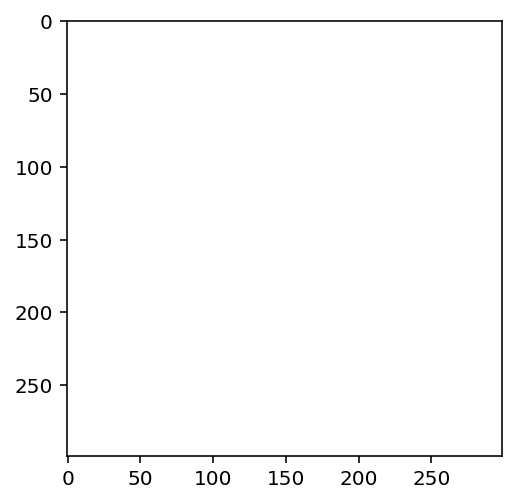

In [44]:
sample_image_idx = 4

plt.imshow((images[sample_image_idx] + 1) / 2)

# Transform Images to Lower Feature Space (Bottleneck)

In [21]:
base_model = Xception(include_top=False,
                      weights='imagenet',
                      input_shape=(img_w_size, img_h_size, 3),
                      pooling='avg')

In [22]:
bottlenecks = base_model.predict(images)

bottlenecks.shape

(200, 2048)

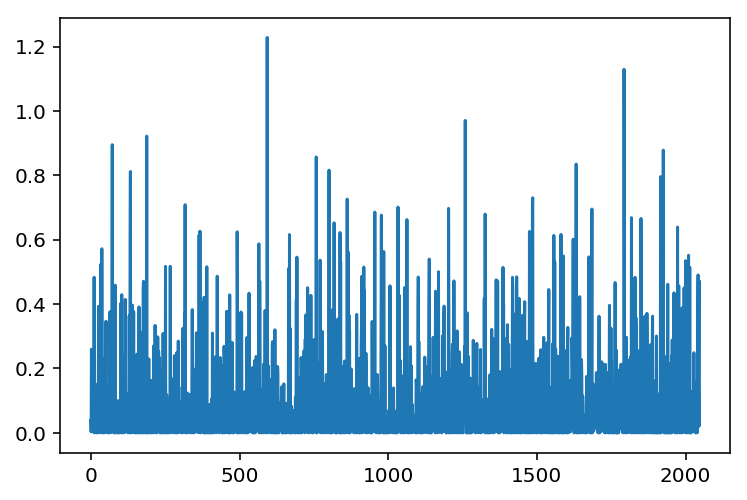

In [23]:
plt.plot(bottlenecks[0])
plt.show()

In [24]:
from sklearn.neighbors import DistanceMetric

In [25]:
dist = DistanceMetric.get_metric('euclidean')

In [26]:
bn_dist = dist.pairwise(bottlenecks)

bn_dist.shape

(200, 200)

# Pre-Process Image Similarities

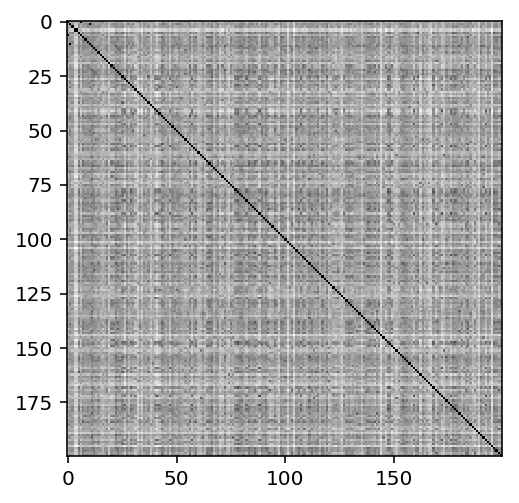

In [27]:
plt.imshow(bn_dist, cmap='gray')

In [28]:
n_rows = 5
n_cols = 5
n_result_images = n_rows * n_cols

# Find Similar Images

## Define `image_search()`

In [29]:
def image_search(img_index, n_rows=n_rows, n_columns=n_cols):
    n_images = n_rows * n_cols

    # create Pandas Series with distances from image
    dist_from_sel = pd.Series(bn_dist[img_index])
    
    # sort Series and get top n_images
    retrieved_indexes = dist_from_sel.sort_values().head(n_images)
    retrieved_images = []
    
    # create figure, loop over closest images indices 
    # and display them
    plt.figure(figsize=(10, 10))
    i = 1
    for idx in retrieved_indexes.index:
        plt.subplot(n_rows, n_cols, i)
        plt.imshow((images[idx] + 1) / 2)
        if i == 1:
            plt.title('Selected image')
        else:
            plt.title("Dist: {:0.4f}".format(retrieved_indexes[idx]))
        i += 1
        retrieved_images += [images[idx]]
        
    plt.tight_layout()
    
    return np.array(retrieved_images)

# Perform Image Search

(25, 299, 299, 3)

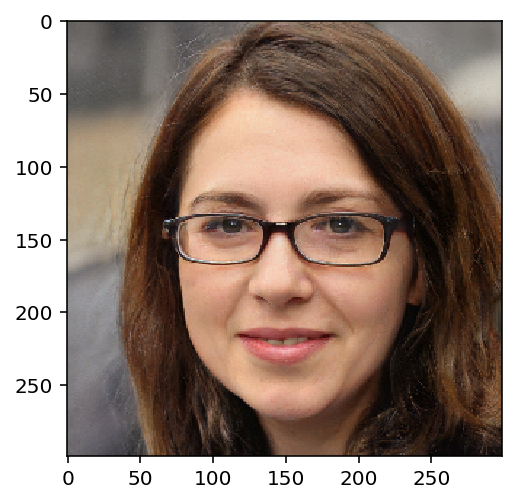

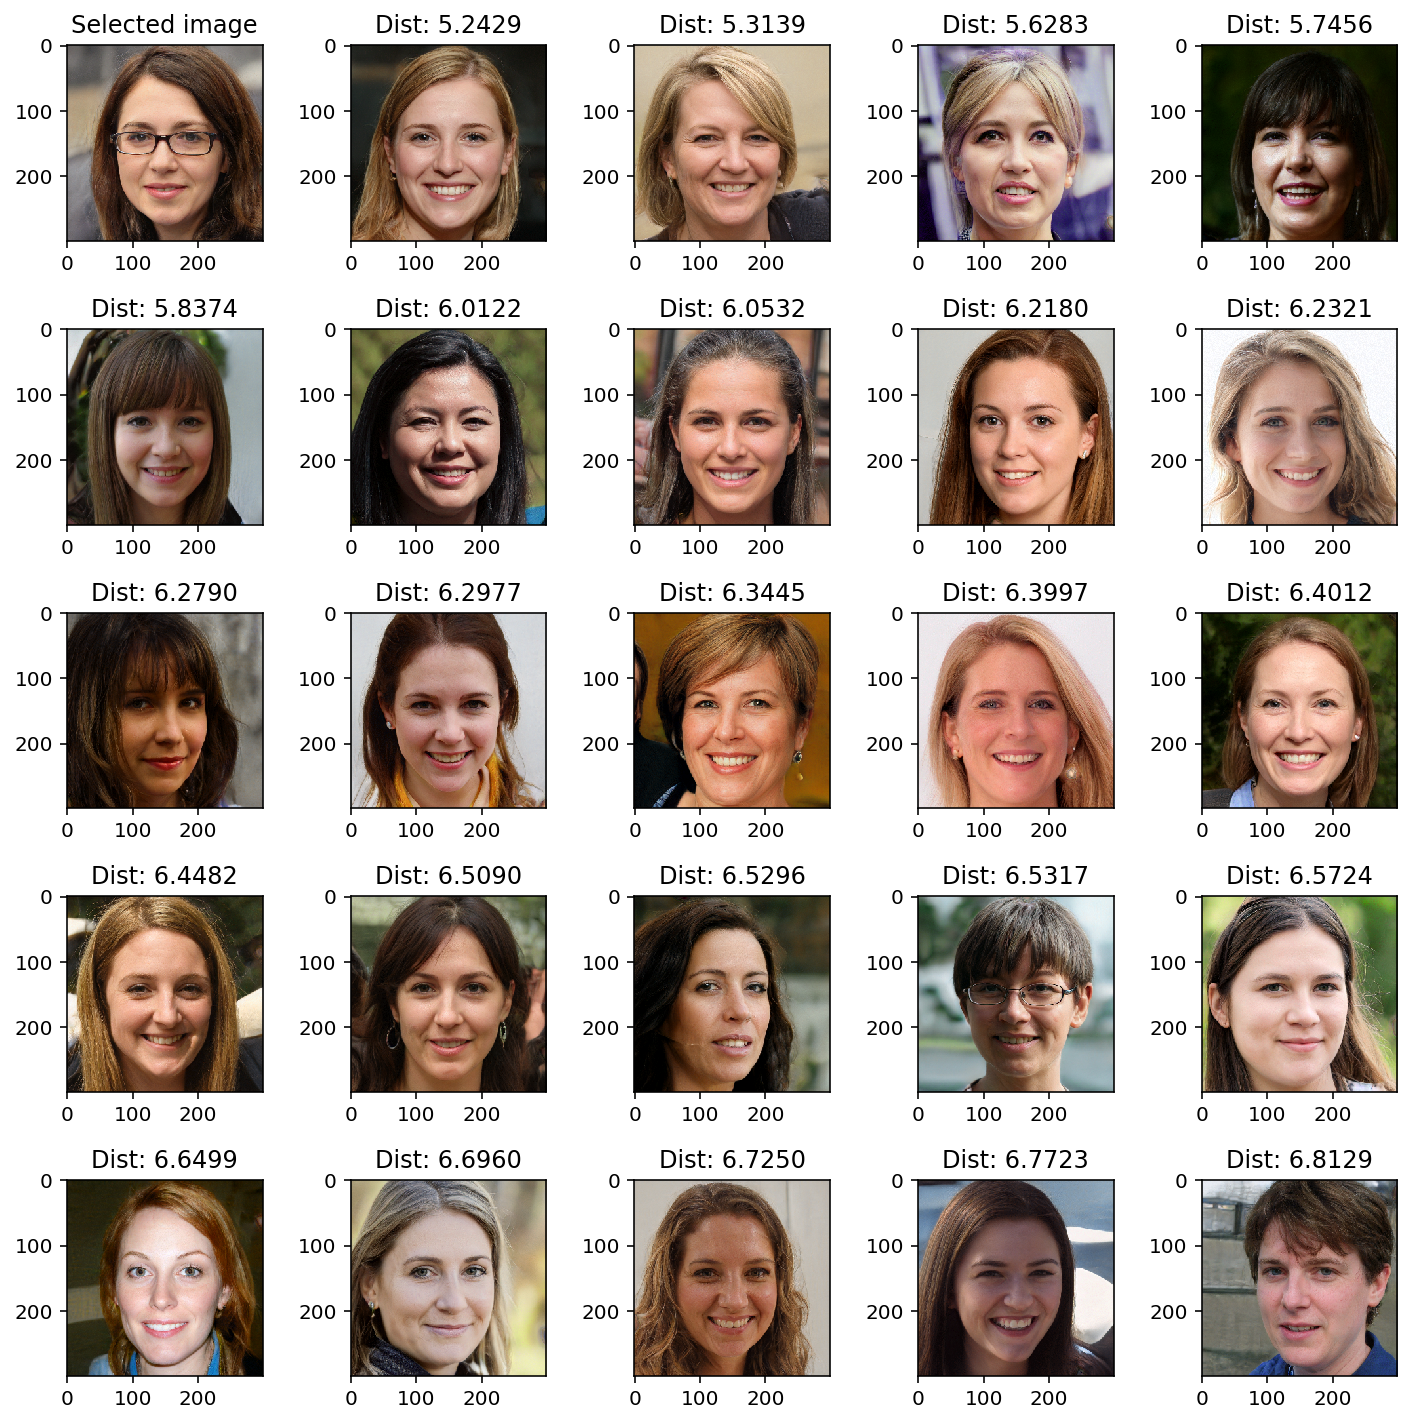

In [30]:
similar_to_idx = 99
plt.imshow((images[similar_to_idx] + 1) / 2)

similar_images_sorted = image_search(similar_to_idx)
similar_images_sorted.shape

In [31]:
#similar_images_sorted_flattened = similar_images_sorted.reshape(n_result_images, -1)
#similar_images_sorted_flattened.shape

# Find the "Average Face" of Similar Images

In [32]:
#similar_images_sorted_flattened_swapped = np.swapaxes(similar_images_sorted_flattened, 0, 1)

#plt.plot(similar_images_sorted_flattened)
#plt.show()

#num_bins = 5000

#fig, ax = plt.subplots()

# the histogram of the data
#n, bins, patches = ax.hist(similar_images_sorted_flattened_swapped, num_bins, density=1)

# add a 'best fit' line
#ax.plot(bins, y, '--')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
#plt.show()

## Convert images to gray-scale

In [33]:
grayscaled_similar_images_sorted = similar_images_sorted.mean(axis=3)

flattened_grayscale_images = grayscaled_similar_images_sorted.reshape(n_result_images, -1)

flattened_grayscale_images.shape

(25, 89401)

In [34]:
_, h, w = grayscaled_similar_images_sorted.shape

# Compute a PCA 
n_components = 10

pca = PCA(n_components=n_components, whiten=True).fit(flattened_grayscale_images)

# apply PCA transformation to training data
pca_transformed = pca.transform(flattened_grayscale_images)

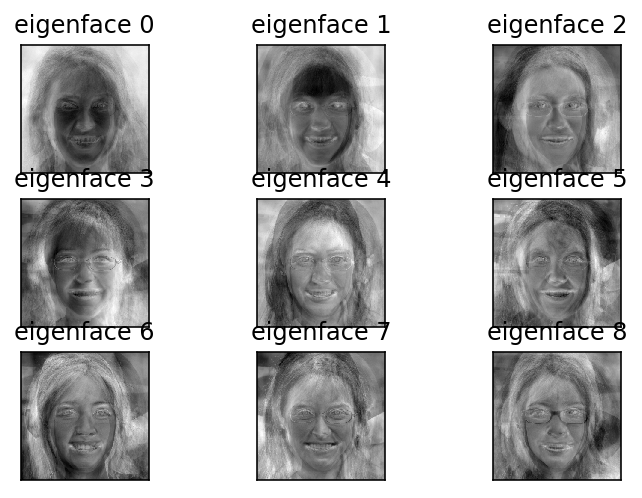

In [35]:
# Visualization
def plot_gallery(images, titles, h, w, rows=n_rows, cols=n_cols):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape(h, w), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, 3, 3)

plt.show()

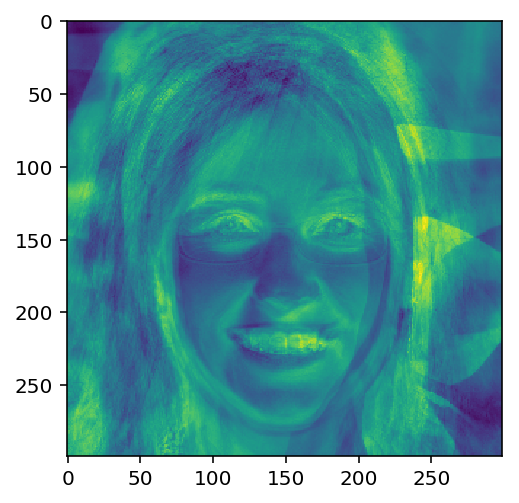

In [36]:
average_face = eigenfaces[9]

plt.imshow((average_face + 1) / 2)

# TODO:  Re-Calculate Image Similarities With New Average Face

In [37]:
save_image_path = os.path.join(images_path, 'gan-0/eigenface0.png')

plt.savefig(fname=save_image_path, format="png")

<Figure size 432x288 with 0 Axes>

# TODO:  Perform Image Search for Average Face
image_search(average_face)

In [38]:
# average_face_image_idx = 13800

# plt.imshow((images[average_face_image_idx] + 1) / 2)

# image_search(images[average_face_image_idx])